# Web Scrapping Project: Web Scrapped thousands of books and gathered meaningful data
 


# Name: Shaikh Ibrahim Rahman

In [117]:
import pandas as pd

In [13]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
from selenium.common.exceptions import TimeoutException

# Function to close popup ads if they appear
def close_popup(driver):
    try:
        close_button = driver.find_element(By.XPATH, "//button[@aria-label='Close'] | //button[contains(@class, 'close')]")
        driver.execute_script("arguments[0].click();", close_button)
    except:
        pass  # Silently ignore if no popup is found

# List of URLs for all pages
urls = [f"https://www.goodreads.com/list/best_of_year/2020?id=143444.Best_Books_of_2020&page={i}" for i in range(1, 17)]

# Set up the WebDriver
driver = webdriver.Chrome()
driver.set_page_load_timeout(120)  # Set timeout for loading pages
book_data = []  # List to store all book details

# Loop through each URL (page)
for url in urls:
    try:
        driver.get(url)
        print(f"Processing URL: {url}")
        time.sleep(3)  # Delay to prevent server throttling

        # Wait for the book links to load
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//a[@class='bookTitle']")))

        # Extract book links
        book_links = [book.get_attribute("href") for book in driver.find_elements(By.XPATH, "//a[@class='bookTitle']")]
       
        print(f"Found {len(book_links)} books on this page.")
        
        # Loop through each book link to scrape details
        for rank, link in enumerate(book_links, start=1):
            try:
                driver.get(link)
                time.sleep(2)  # Delay to avoid request overload
                close_popup(driver)  # Close any popup that appears
                
                # Wait for the book page to load
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//h1[@data-testid='bookTitle']")))
                
                # Extract Title
                try:
                    title = driver.find_element(By.XPATH, "//h1[@data-testid='bookTitle']").text
                except:
                    title = 'N/A'

                
                # Extract publication date
                try:
                    publication_date_text = driver.find_element(By.XPATH, "//p[@data-testid='publicationInfo']").text
                    year = publication_date_text.split()[-1]  # Extract the last part (year)
                except:
                    year = 'N/A'
                    publication_date_text = 'N/A'

                
                # Extract author name
                try:
                    author = driver.find_element(By.XPATH, "//span[@data-testid='name']").text
                except:
                    author = 'N/A'

                
                # Extract genre
                try:
                    # Locate the first genre element and extract its text
                    genre = driver.find_element(By.XPATH, "//span[contains(@class, 'BookPageMetadataSection__genreButton')]//span[@class='Button__labelItem']").text
                except:
                    genre = 'N/A'

                
                # Extract average rating                
                try:
                    average_rating = driver.find_element(By.XPATH, "//div[@class='RatingStatistics__rating']").text
                except:
                    average_rating = 'N/A'

                
                # Extraxt number of ratings
                try:
                    num_ratings = driver.find_element(By.XPATH, "//span[@data-testid='ratingsCount']").text.split(' ')[0]
                except:
                    num_ratings = 'N/A'

                
                # Extract number of pages
                try:
                    num_pages = driver.find_element(By.XPATH, "//p[@data-testid='pagesFormat']").text.split(' ')[0]
                except:
                    num_pages = 'N/A'
                    
                
                # Extract Language
                try:
                    book_details_button = driver.find_element(By.XPATH, "//button[@aria-label='Book details and editions']")
                    driver.execute_script("arguments[0].click();", book_details_button)
                    time.sleep(1)
                    language = WebDriverWait(driver, 5).until(
                        EC.presence_of_element_located((By.XPATH, "//dt[text()='Language']/following-sibling::dd//div"))
                    ).text
                except:
                    language = "N/A"

                
                # Extract number of people (Currently Reading)
                try:
                    currently_reading = driver.find_element(By.XPATH, "//div[@data-testid='currentlyReadingSignal']").text
                    currently_reading = currently_reading.split(' ')[0]  # Extract the numeric part
                except:
                    currently_reading = 'N/A'

                # Extract number of people (Want to Read)
                try:
                    want_to_read = driver.find_element(By.XPATH, "//div[@data-testid='toReadSignal']").text
                    want_to_read = want_to_read.split(' ')[0]  # Extract the numeric part
                except:
                    want_to_read = 'N/A'

                 

                # Add data to list
                book_data.append({
                    'Title': title,
                    'Publication Year': year,
                    'Author': author,
                    'Genre': genre,
                    'Average Rating': average_rating,
                    'Number of Ratings': num_ratings,
                    'Number of Pages': num_pages,
                    'Language': language,
                    'Currently Reading': currently_reading,
                    'Want to Read': want_to_read,
                    'Rank': rank + (urls.index(url) * len(book_links))  # Adjust rank across pages
                })
                # Print the scraped data for each book
                print(f"Rank: {rank}")
                print(f"Title: {title}")
                print(f"Publication Date: {publication_date_text}")
                print(f"Author: {author}")
                print(f"Genre: {genre}")
                print(f"Average Rating: {average_rating}")
                print(f"Number of Ratings: {num_ratings}")
                print(f"Number of Pages: {num_pages}")
                print(f"Language: {language}")
                print(f"Currently Reading: {currently_reading}")
                print(f"Want to Read: {want_to_read}")
                print("-" * 50)
            
            except TimeoutException:
                print(f"Timeout occurred for link: {link}")
            except Exception as e:
                print(f"Error scraping book {link}: {e}")
    
    except Exception as e:
        print(f"Error processing page {url}: {e}")
        continue

# Close the WebDriver
driver.quit()

# Convert to DataFrame
df = pd.DataFrame(book_data)

# Clean up numeric fields
df['Publication Year'] = pd.to_numeric(df['Publication Year'], errors='coerce')
df['Average Rating'] = pd.to_numeric(df['Average Rating'], errors='coerce')
df['Number of Ratings'] = pd.to_numeric(df['Number of Ratings'].str.replace(',', ''), errors='coerce')
df['Number of Pages'] = pd.to_numeric(df['Number of Pages'], errors='coerce')

# Convert 'k' and 'm' notations to integers for 'Currently Reading' and 'Want to Read'
df['Currently Reading'] = df['Currently Reading'].str.replace(',', '', regex=False)
df['Currently Reading'] = df['Currently Reading'].apply(
    lambda x: int(float(x.replace('k', '')) * 1000) if 'k' in x else
              int(float(x.replace('m', '')) * 1000000) if 'm' in x else
              int(x) if x.isdigit() else None
)

df['Want to Read'] = df['Want to Read'].str.replace(',', '', regex=False)
df['Want to Read'] = df['Want to Read'].apply(
    lambda x: int(float(x.replace('k', '')) * 1000) if 'k' in x else
              int(float(x.replace('m', '')) * 1000000) if 'm' in x else
              int(x) if x.isdigit() else None
)


Processing URL: https://www.goodreads.com/list/best_of_year/2020?id=143444.Best_Books_of_2020&page=1
Found 100 books on this page.
Rank: 1
Title: The House in the Cerulean Sea
Publication Date: First published March 16, 2020
Author: T.J. Klune
Genre: Fantasy
Average Rating: 4.39
Number of Ratings: 747,551
Number of Pages: 394
Language: N/A
Currently Reading: 40.2k
Want to Read: 869k
--------------------------------------------------
Rank: 2
Title: House of Earth and Blood
Publication Date: First published March 3, 2020
Author: Sarah J. Maas
Genre: Romance
Average Rating: 4.47
Number of Ratings: 858,215
Number of Pages: 803
Language: English
Currently Reading: 71.6k
Want to Read: 959k
--------------------------------------------------
Rank: 3
Title: The Invisible Life of Addie LaRue
Publication Date: First published October 6, 2020
Author: Victoria E. Schwab
Genre: Fantasy
Average Rating: 4.18
Number of Ratings: 1,227,862
Number of Pages: 448
Language: English
Currently Reading: 112k
Wa

In [15]:
df

,Title,Publication Year,Author,Genre,Average Rating,Number of Ratings,Number of Pages,Language,Currently Reading,Want to Read,Rank
0,The House in the Cerulean Sea,2020,T.J. Klune,Fantasy,4.39,747551,394.0,N/A,40200.0,869000.0,1
1,House of Earth and Blood,2020,Sarah J. Maas,Romance,4.47,858215,803.0,English,71600.0,959000.0,2
2,The Invisible Life of Addie LaRue,2020,Victoria E. Schwab,Fantasy,4.18,1227862,448.0,English,112000.0,2000000.0,3
3,American Dirt,2020,Jeanine Cummins,Fiction,4.37,616937,459.0,English,66700.0,417000.0,4
4,The Midnight Library,2020,Matt Haig,Fiction,3.99,2027688,288.0,English,106000.0,2000000.0,5
...,...,...,...,...,...,...,...,...,...,...,...
1535,The Rule of All,2020,Ashley Saunders,Dystopia,3.94,1587,338.0,English,304.0,2256.0,668
1536,The Room Upstairs: A Supernatural Horror Novel,2020,Iain Rob Wright,Horror,4.18,1350,NaN,English,613.0,819.0,669
1537,Golden Gates: Fighting for Housing in America,2020,Conor Dougherty,Nonfiction,4.07,2572,288.0,English,445.0,7375.0,670
1538,Broken Faith: Inside the Word of Faith Fellows...,2020,Mitch Weiss,Nonfiction,4.15,3547,416.0,N/A,735.0,4623.0,671


In [25]:
import pandas as pd

# Save the DataFrame to a CSV file
file_path = 'scraped_books.csv'  # Specify your desired file name
df.to_csv(file_path, index=False)

print(f"CSV file saved at: {file_path}")

CSV file saved at: scraped_books.csv


In [31]:
import pandas as pd

# Ensure 'Average Rating' and 'Rank' are numeric
df['Average Rating'] = pd.to_numeric(df['Average Rating'], errors='coerce')
df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce')

# Group by Genre and calculate average rating and average rank
genre_summary = df.groupby('Genre').agg(
    Average_Rating=('Average Rating', 'mean'),
    Average_Rank=('Rank', 'mean')
).reset_index()

# Sort by Average Rating in descending order
genre_summary = genre_summary.sort_values(by='Average_Rating', ascending=False)

# Display the top 2-3 genres with the highest ratings
top_genres = genre_summary.head(3)

# Print the summary table
print("Genre Ratings Summary:")
print(genre_summary)

# Print the top genres
print("\nTop 2-3 Genres with Highest Ratings:")
print(top_genres


# Genre ratings:
# Compare average ratings across genres. Which 2-3 genres tends to have the highest ratings? 

'''
Genre Ratings: Observations
Based on the comparison of average ratings across genres:

Overall Range of Ratings:

The average ratings across all genres fall within a range of 3.22 to 4.34.
This indicates that the ratings are generally positive, with even the lowest-rated genres not falling below 3.0.
Top-Rated Genres:

Genres such as Colouring Books, Plays, Tarot, Children's, and Art consistently achieve higher average ratings above 4.0.
These genres may appeal to niche audiences or elicit strong emotional connections, leading to higher ratings.
Mid-Tier Genres:

Genres like Fantasy, History, Humor, Mystery, Fiction, and Horror have slightly lower average ratings, 
typically ranging between 3.7 and 3.96.
These genres still maintain relatively high ratings, likely due to their widespread appeal and established fan bases.
Lowest-Rated Genres:

Genres such as Education, Vampires, and Short Stories fall on the lower end of the scale, with average ratings closer to 3.22.
These may reflect more critical audience reviews or less mainstream appeal.
Top 5 Genres by Average Rating:

Colouring Books, Plays, Tarot, Children's, and Art stand out as the highest-rated genres, 
showcasing a clear preference among readers for these categories.

Key Insights:

The analysis highlights the diversity in audience preferences across genres. 
Niche and artistic genres like Plays, Art, and Tarot attract high ratings, likely due to their specialized audiences. 
In contrast, genres with broader appeal, such as Fantasy and Fiction, show slightly lower average ratings, potentially 
reflecting the varied tastes and expectations of a larger readership. 
The lowest-rated genres, such as Education and Vampires, 
may cater to specific needs or trends that do not resonate as strongly with general audiences.
'''


Genre Ratings Summary:
              Genre  Average_Rating  Average_Rank
9   Colouring Books        4.340000    507.000000
27            Plays        4.330000   1831.000000
33            Tarot        4.330000   1727.000000
7         Childrens        4.310000   1345.000000
1               Art        4.224706   1629.529412
20            Magic        4.150000   1716.000000
16   Graphic Novels        4.088640    751.448000
32      Superheroes        4.080000    473.000000
6          Business        4.070000   1385.000000
8          Classics        4.068000   1426.800000
10           Comics        4.058289    737.184492
25       Nonfiction        4.052895   1310.789474
3    Bande Dessinée        4.005000    900.166667
26    Picture Books        3.973636    347.181818
12       Doctor Who        3.967778   1413.444444
14          Fantasy        3.967673   1019.076364
2         Audiobook        3.948333    489.333333
17          History        3.945000   1734.000000
19            Humor        

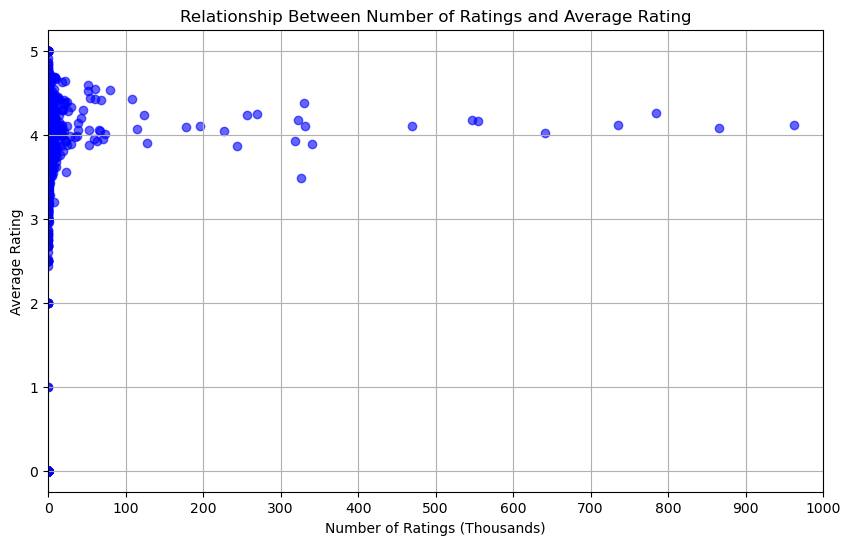

In [129]:
# Average Rating Vs Number of Ratings

import pandas as pd
import matplotlib.pyplot as plt

# Ensure columns are numeric
df['Number of Ratings'] = pd.to_numeric(df['Number of Ratings'], errors='coerce')
df['Average Rating'] = pd.to_numeric(df['Average Rating'], errors='coerce')

# Drop rows with missing or invalid data
df_cleaned = df.dropna(subset=['Number of Ratings', 'Average Rating'])

# Scatterplot: Number of Ratings vs Average Rating
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['Number of Ratings'] / 1000, df_cleaned['Average Rating'], alpha=0.6, color='blue')  # Scale x-axis to thousands

# Set x-axis limits and ticks
plt.xticks(range(0, 1001, 100))  # Tick marks from 0 to 250 with intervals of 50
plt.xlim(0, 1000)  # X-axis range from 0 to 250

# Add labels, title, and grid
plt.title("Relationship Between Number of Ratings and Average Rating")
plt.xlabel("Number of Ratings (Thousands)")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()


# Popularity and ratings:
# Examine whether books with more ratings tend to have higher or lower average scores. 
# Create a scatterplot showing the relationship between the number of ratings and average rating. 
# On the x-axis, you should have number of ratings; on the y-axis, you should have average rating.

'''
Initial Trend (Crowded Data Points):

When the scatterplot is congested in the lower range of the x-axis (fewer ratings), there appears to be a negative relationship.
As the number of ratings increases, the average rating tends to decrease. 
This suggests that highly-rated books may initially attract fewer ratings, potentially from niche or loyal audiences.

Mid-Range Stability:

As the number of ratings increases further, the average rating begins to stabilize around 4.0.
The relationship appears almost linear, with less variation in average ratings despite a wider range of rating counts.
Overall Trend:

Books with fewer ratings tend to have higher average scores, possibly due to a smaller and more targeted audience. 
Conversely, as more people rate the book, the scores tend to converge, possibly reflecting a broader and more diverse audience.
Key Insight:

While the initial part of the graph shows a decline in average ratings as popularity (ratings count) grows, 
the ratings become more consistent at a slightly lower level (~4.0) as the number of ratings increases.
This pattern highlights the potential influence of audience size and diversity on ratings. 
Books with limited reach may maintain higher average ratings, but as they gain popularity and attract a wider audience, 
the scores tend to level off, reflecting more balanced opinions.
'''


In [17]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time

# Function to close popup ads if they appear
def close_popup(driver):
    try:
        close_button = driver.find_element(By.XPATH, "//button[@aria-label='Close'] | //button[contains(@class, 'close')]")
        driver.execute_script("arguments[0].click();", close_button)
    except:
        pass  # Silently ignore if no popup is found

# List of URLs for all pages
urls = [f"https://www.goodreads.com/author/list/1221698.Neil_Gaiman?page={i}&per_page=30" for i in range(1, 71)]

# Set up the WebDriver
driver = webdriver.Chrome()
driver.set_page_load_timeout(120)  # Set timeout for loading pages
book_data = []  # List to store all book details

# Loop through each URL (page)
for url in urls:
    try:
        driver.get(url)
        print(f"Processing URL: {url}")
        time.sleep(3)  # Delay to prevent server throttling

        # Wait for the book links to load
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//a[@class='bookTitle']")))

        # Extract book links
        book_links = [book.get_attribute("href") for book in driver.find_elements(By.XPATH, "//a[@class='bookTitle']")]
        #book_links = book_links[:5]  # Limit to first 15 books on each page (for testing)
        print(f"Found {len(book_links)} books on this page.")
        
        # Loop through each book link to scrape details
        for rank, link in enumerate(book_links, start=1):
            try:
                driver.get(link)
                time.sleep(2)  # Delay to avoid request overload
                close_popup(driver)  # Close any popup that appears
                
                # Wait for the book page to load
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//h1[@data-testid='bookTitle']")))
                
                # Extract Title
                try:
                    title = driver.find_element(By.XPATH, "//h1[@data-testid='bookTitle']").text
                except:
                    title = 'N/A'

                
                # Extract publication date
                try:
                    publication_date_text = driver.find_element(By.XPATH, "//p[@data-testid='publicationInfo']").text
                    year = publication_date_text.split()[-1]  # Extract the last part (year)
                except:
                    year = 'N/A'
                    publication_date_text = 'N/A'

                
                # Extract author name
                try:
                    author = driver.find_element(By.XPATH, "//span[@data-testid='name']").text
                except:
                    author = 'N/A'
                
                # Extract genre
                try:
                    # Locate the first genre element and extract its text
                    genre = driver.find_element(By.XPATH, "//span[contains(@class, 'BookPageMetadataSection__genreButton')]//span[@class='Button__labelItem']").text
                except:
                    genre = 'N/A'


                # Extract average rating    
                try:
                    average_rating = driver.find_element(By.XPATH, "//div[@class='RatingStatistics__rating']").text
                except:
                    average_rating = 'N/A'


                # Extraxt number of ratings
                try:
                    num_ratings = driver.find_element(By.XPATH, "//span[@data-testid='ratingsCount']").text.split(' ')[0]
                except:
                    num_ratings = 'N/A'


                # Extract number of pages
                try:
                    num_pages = driver.find_element(By.XPATH, "//p[@data-testid='pagesFormat']").text.split(' ')[0]
                except:
                    num_pages = 'N/A'

                
                # Extract Language
                try:
                    book_details_button = driver.find_element(By.XPATH, "//button[@aria-label='Book details and editions']")
                    driver.execute_script("arguments[0].click();", book_details_button)
                    time.sleep(1)
                    language = WebDriverWait(driver, 5).until(
                        EC.presence_of_element_located((By.XPATH, "//dt[text()='Language']/following-sibling::dd//div"))
                    ).text
                except:
                    language = "N/A"

                
                # Extract number of people (Currently Reading)
                try:
                    currently_reading = driver.find_element(By.XPATH, "//div[@data-testid='currentlyReadingSignal']").text
                    currently_reading = currently_reading.split(' ')[0]  # Extract the numeric part
                except:
                    currently_reading = 'N/A'

                
                # Extract number of people (Want to Read)
                try:
                    want_to_read = driver.find_element(By.XPATH, "//div[@data-testid='toReadSignal']").text
                    want_to_read = want_to_read.split(' ')[0]  # Extract the numeric part
                except:
                    want_to_read = 'N/A'

                 

                # Add data to list
                book_data.append({
                    'Title': title,
                    'Publication Year': year,
                    'Author': author,
                    'Genre': genre,
                    'Average Rating': average_rating,
                    'Number of Ratings': num_ratings,
                    'Number of Pages': num_pages,
                    'Language': language,
                    'Currently Reading': currently_reading,
                    'Want to Read': want_to_read,
                    'Rank': rank + (urls.index(url) * len(book_links))  # Adjust rank across pages
                })
                # Print the scraped data for each book
                print(f"Rank: {rank}")
                print(f"Title: {title}")
                print(f"Publication Date: {publication_date_text}")
                print(f"Author: {author}")
                print(f"Genre: {genre}")
                print(f"Average Rating: {average_rating}")
                print(f"Number of Ratings: {num_ratings}")
                print(f"Number of Pages: {num_pages}")
                print(f"Language: {language}")
                print(f"Currently Reading: {currently_reading}")
                print(f"Want To Read: {want_to_read}")
                print("-" * 50)
            
            except TimeoutException:
                print(f"Timeout occurred for link: {link}")
            except Exception as e:
                print(f"Error scraping book {link}: {e}")
    
    except Exception as e:
        print(f"Error processing page {url}: {e}")
        continue

# Close the WebDriver
driver.quit()

# Convert to DataFrame
df2 = pd.DataFrame(book_data)

# Clean up numeric fields
df2['Publication Year'] = pd.to_numeric(df2['Publication Year'], errors='coerce')
df2['Average Rating'] = pd.to_numeric(df2['Average Rating'], errors='coerce')
df2['Number of Ratings'] = pd.to_numeric(df2['Number of Ratings'].str.replace(',', ''), errors='coerce')
df2['Number of Pages'] = pd.to_numeric(df2['Number of Pages'], errors='coerce')

# Convert 'k' and 'm' notations to integers for 'Currently Reading' and 'Want to Read'
df2['Currently Reading'] = df2['Currently Reading'].str.replace(',', '', regex=False)
df2['Currently Reading'] = df2['Currently Reading'].apply(
    lambda x: int(float(x.replace('k', '')) * 1000) if 'k' in x else
              int(float(x.replace('m', '')) * 1000000) if 'm' in x else
              int(x) if x.isdigit() else None
)

df2['Want to Read'] = df2['Want to Read'].str.replace(',', '', regex=False)
df2['Want to Read'] = df2['Want to Read'].apply(
    lambda x: int(float(x.replace('k', '')) * 1000) if 'k' in x else
              int(float(x.replace('m', '')) * 1000000) if 'm' in x else
              int(x) if x.isdigit() else None
)


Processing URL: https://www.goodreads.com/author/list/1221698.Neil_Gaiman?page=1&per_page=30
Found 30 books on this page.
Rank: 1
Title: American Gods
Publication Date: First published June 19, 2001
Author: Neil Gaiman
Genre: Fantasy
Average Rating: 4.11
Number of Ratings: 961,872
Number of Pages: 635
Language: N/A
Currently Reading: 47k
Want To Read: 755k
--------------------------------------------------
Rank: 2
Title: Coraline
Publication Date: First published July 2, 2002
Author: Neil Gaiman
Genre: Fantasy
Average Rating: 4.12
Number of Ratings: 735,467
Number of Pages: 176
Language: English
Currently Reading: 12k
Want To Read: 655k
--------------------------------------------------
Rank: 3
Title: The Ocean at the End of the Lane
Publication Date: First published June 18, 2013
Author: Neil Gaiman
Genre: Fantasy
Average Rating: 4.02
Number of Ratings: 640,751
Number of Pages: 195
Language: English
Currently Reading: 14.9k
Want To Read: 527k
------------------------------------------

In [23]:
# dataframe made from the given link
df2

# new dataframe where the author is Neil Gaiman

df3 = df2[df2['Author'] == 'Neil Gaiman'].copy()

df3

,Title,Publication Year,Author,Genre,Average Rating,Number of Ratings,Number of Pages,Language,Currently Reading,Want to Read,Rank
0,American Gods,2001.0,Neil Gaiman,Fantasy,4.11,961872,635.0,N/A,47000.0,755000.0,1
1,Coraline,2002.0,Neil Gaiman,Fantasy,4.12,735467,176.0,English,12000.0,655000.0,2
2,The Ocean at the End of the Lane,2013.0,Neil Gaiman,Fantasy,4.02,640751,195.0,English,14900.0,527000.0,3
3,The Graveyard Book,2008.0,Neil Gaiman,Fantasy,4.16,554504,312.0,English,13400.0,424000.0,4
4,Neverwhere,1996.0,Neil Gaiman,Fantasy,4.17,546946,370.0,English,19700.0,489000.0,5
...,...,...,...,...,...,...,...,...,...,...,...
1344,Miracleman vol. 4 - L'età deell'oro,2021.0,Neil Gaiman,N/A,0.00,0,192.0,Italian,NaN,NaN,1348
1345,Anansi Boys Volume 1,2025.0,Neil Gaiman,N/A,0.00,0,200.0,English,NaN,4.0,1349
1346,La Mythologie viking: BD3,2024.0,Neil Gaiman,N/A,0.00,0,152.0,French,NaN,NaN,1350
1620,Acolytes of Cthulhu,2000.0,Neil Gaiman,Horror,3.60,317,469.0,English,93.0,367.0,1626


In [33]:
# Language distribution.
# It shows the number of books, the author published in different languages

import pandas as pd

# Convert to DataFrame
df2 = pd.DataFrame(book_data)

# Clean up missing or 'N/A' values in Language column
df2['Language'] = df2['Language'].replace('N/A', 'Unknown')

# Group by Language and count the number of books
language_counts = df2['Language'].value_counts().reset_index()
language_counts.columns = ['Language', 'Book Count']

# Display the table
print("Language Distribution:")
print(language_counts)


Language Distribution:
                 Language  Book Count
0                 English        1431
1                 Unknown         267
2      Spanish; Castilian         111
3                 Italian          82
4                  French          50
5              Portuguese          45
6                  German          26
7                  Polish          21
8                 Russian          21
9                  Arabic           5
10  Greek, Modern (1453-)           5
11                Chinese           4
12                Finnish           4
13                  Czech           3
14               Croatian           3
15                Serbian           2
16                Turkish           2
17              Hungarian           2
18               Japanese           1
19                 Korean           1
20         Dutch; Flemish           1
21             Vietnamese           1
22              Norwegian           1
23                 Hebrew           1
24             Indonesian  

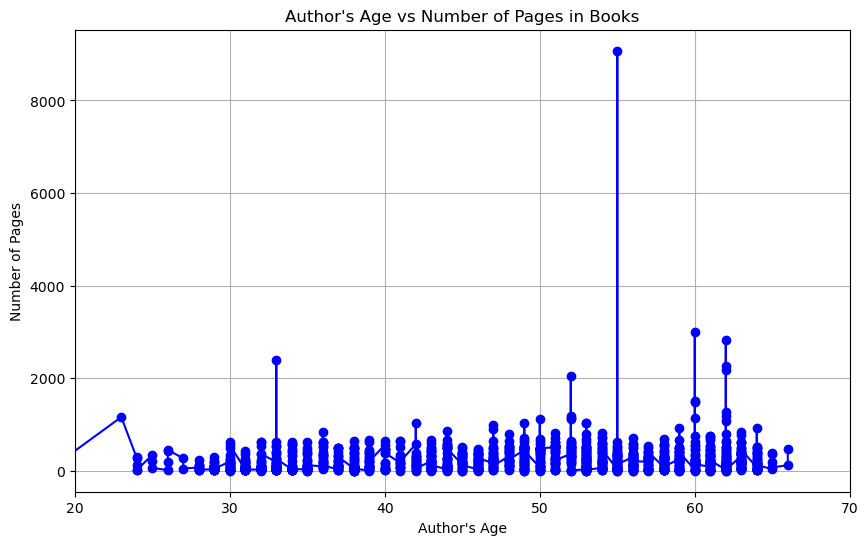

In [132]:
# Author age vs page count

import pandas as pd
import matplotlib.pyplot as plt

# Calculate author's age at the time of publication
current_year = 2024  
neil_age = 64
author_birth_year = current_year - neil_age  # Calculate birth year

df2['Publication Year'] = pd.to_numeric(df2['Publication Year'], errors='coerce')

# Calculate Author Age directly without using lambda
df2['Author Age'] = df2['Publication Year'] - author_birth_year

# Replace invalid values with None
df2['Author Age'] = df2['Author Age'].where(df2['Publication Year'].notnull(), None)

# Filter out non-numeric 'Number of Pages' and drop rows with missing data
df_cleaned = df2[df2['Number of Pages'].apply(lambda x: str(x).isnumeric())].copy()
df_cleaned['Number of Pages'] = pd.to_numeric(df_cleaned['Number of Pages'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['Author Age', 'Number of Pages'])

# Filter out negative author ages
df_cleaned = df_cleaned[df_cleaned['Author Age'] >= 0]

# Convert columns to integer for clean plotting
df_cleaned['Author Age'] = df_cleaned['Author Age'].astype(int)
df_cleaned['Number of Pages'] = df_cleaned['Number of Pages'].astype(int)

# Sort by Author Age to make the line plot more meaningful
df_cleaned = df_cleaned.sort_values(by='Author Age')

# Plot: Author's age vs Number of Pages
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['Author Age'], df_cleaned['Number of Pages'], marker='o', linestyle='-', color='b')
plt.title("Author's Age vs Number of Pages in Books")
plt.xlabel("Author's Age")
plt.ylabel("Number of Pages")
plt.grid(True)

# Set x-axis limits and ticks 
plt.xlim(20, 70)
plt.xticks(range(20, 71, 10))  # Intervals of 10

# Show the plot
plt.show()


'''
Author's Age and Page Count: Observations

General Trend:

The line graph shows that page counts remain relatively similar across most age ranges.
There is no drastic fluctuation in the number of pages for books written at different ages.
Positive Relationship:

A slight positive correlation is observed as the author's age increases.
While most books have a consistent page count, longer books tend to appear at older ages.
Consistency in Page Counts:

Across the majority of the graph, the page counts are clustered within a stable range, 
indicating that the author's output in terms of book length does not vary significantly.
High Page Counts at Older Ages:

The highest page counts are observed later in the author's life, 
suggesting a possible trend of taking on larger projects with experience or 
a preference for writing more detailed works at older ages.

Key Insight:
While the overall relationship between author's age and page count is not strongly positive, 
the appearance of longer books later in life suggests a slight trend. 
This could be influenced by the author's growing expertise, confidence, 
or the ability to undertake more ambitious projects as they age.
'''


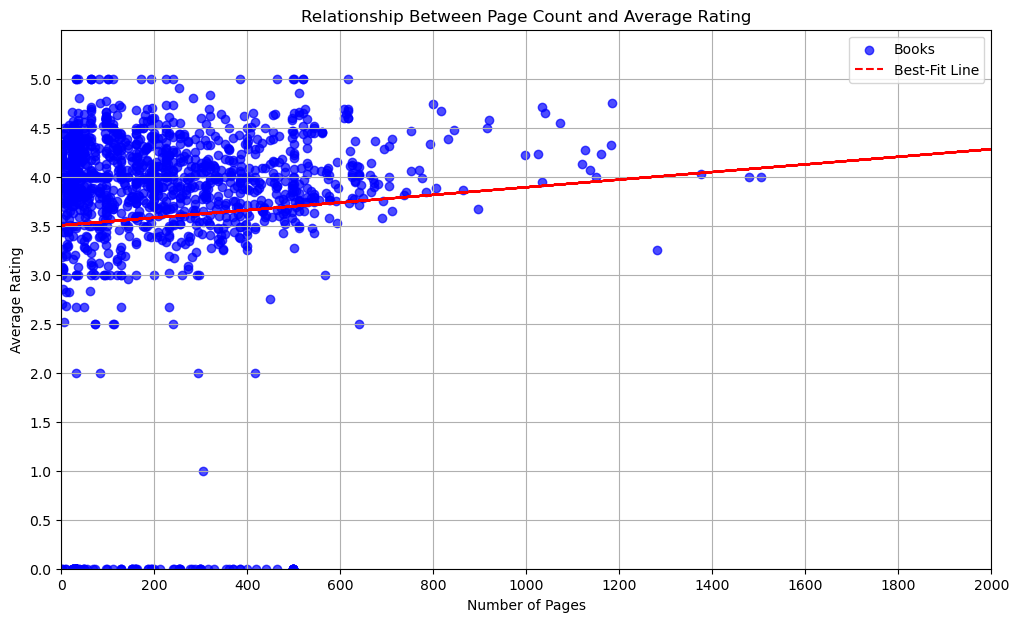

Best-Fit Line Equation: y = 0.00x + 3.50


In [81]:
# Average Rating Vs Page Count

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming the data is in a DataFrame named df
# Clean data: Ensure 'Number of Pages' and 'Average Rating' are numeric
df['Number of Pages'] = pd.to_numeric(df['Number of Pages'], errors='coerce')
df['Average Rating'] = pd.to_numeric(df['Average Rating'], errors='coerce')

# Drop rows with missing values in relevant columns
df_cleaned = df.dropna(subset=['Number of Pages', 'Average Rating']).copy()

# Convert columns to appropriate types
df_cleaned['Number of Pages'] = df_cleaned['Number of Pages'].astype(int)
df_cleaned['Average Rating'] = df_cleaned['Average Rating'].astype(float)

# Scatter Plot: Number of Pages vs Average Rating
plt.figure(figsize=(12, 7))
plt.scatter(df_cleaned['Number of Pages'], df_cleaned['Average Rating'], color='blue', alpha=0.7, label='Books')

# Best-Fit Line
x = df_cleaned['Number of Pages']
y = df_cleaned['Average Rating']
slope, intercept = np.polyfit(x, y, 1)  # Linear regression
best_fit_line = slope * x + intercept

plt.plot(x, best_fit_line, color='red', linestyle='--', label='Best-Fit Line')

# Add labels, title, and grid
plt.title("Relationship Between Page Count and Average Rating")
plt.xlabel("Number of Pages")
plt.ylabel("Average Rating")
plt.xticks(range(0, 2001, 200))  # Set x-axis ticks from 0 to 2000 with intervals of 200
plt.yticks(np.arange(0, max(df_cleaned['Average Rating']) + 0.5, 0.5))  # Set y-axis ticks
plt.xlim(0, 2000)  # Ensure x-axis starts from 0
plt.ylim(0, max(df_cleaned['Average Rating']) + 0.5)  # Ensure y-axis starts from 0
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Print the best-fit line equation
print(f"Best-Fit Line Equation: y = {slope:.2f}x + {intercept:.2f}")

'''
Pages vs. Ratings: Observations
Initial Cluster:

In the initial cluster, the average ratings remain fairly consistent for books with fewer pages.
Low page counts correspond to both high and moderate average ratings.
Lower Ratings for Shorter Books:

Books with lower ratings are predominantly found in the low page count range.
This suggests that shorter books may face more critical reviews or appeal to a smaller audience.
Higher Ratings with Longer Books:

As the number of pages increases, there is a visible trend of higher average ratings.
Longer books tend to have more favorable reviews, possibly due to their depth and comprehensive storytelling.
Outliers with High Page Counts:



The best-fit line drawn on the scatterplot shows a positive slope, 
indicating a positive correlation between page count and average rating.
This trend reinforces the idea that longer books generally receive better ratings, 
though the relationship is not strongly linear.

Key Insight:
The scatterplot suggests a moderate positive relationship between the number of pages and average ratings. 
While shorter books are more likely to receive lower ratings, 
longer books generally fare better, with exceptions for a few outliers. 
The positive gradient of the best-fit line highlights this trend.
'''




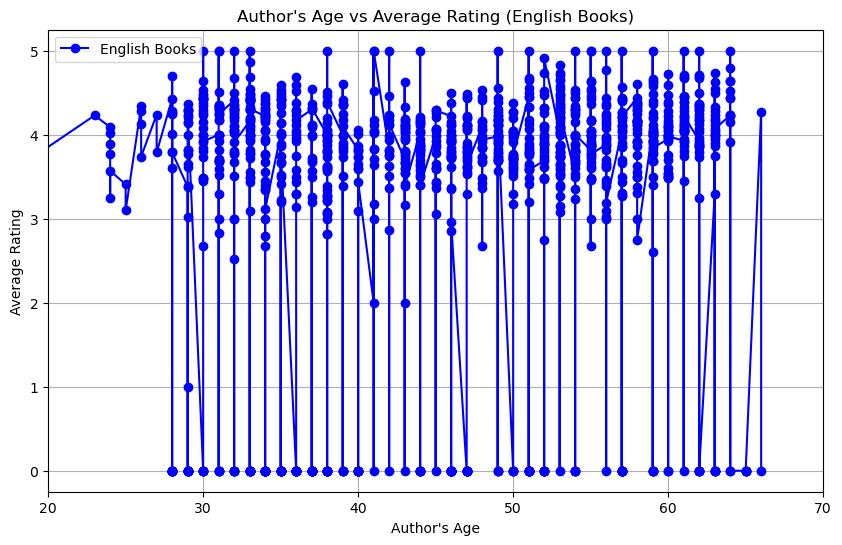

In [91]:
# Author age and average rating (english only)

import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is in a DataFrame named df2
# Clean data: Ensure 'Average Rating' and 'Publication Year' are numeric
df2['Publication Year'] = pd.to_numeric(df2['Publication Year'], errors='coerce')
df2['Average Rating'] = pd.to_numeric(df2['Average Rating'], errors='coerce')

# Filter for English-only books and create a copy
df2_english = df2[df2['Language'] == 'English'].copy()

# Calculate author's age at the time of publication
current_year = 2024  # Assuming current year is 2024
neil_age = 64
author_birth_year = current_year - neil_age  # Calculate birth year
df2_english['Author Age'] = df2_english['Publication Year'] - author_birth_year

# Drop rows with missing or invalid data and filter out negative or unrealistic ages
df2_cleaned = df2_english.dropna(subset=['Author Age', 'Average Rating']).copy()
df2_cleaned = df2_cleaned[df2_cleaned['Author Age'] >= 0]  # Filter out negative ages

# Convert columns to appropriate types
df2_cleaned['Author Age'] = df2_cleaned['Author Age'].astype(int)
df2_cleaned['Average Rating'] = df2_cleaned['Average Rating'].astype(float)

# Sort the data by Author Age for a smooth line plot
df2_cleaned = df2_cleaned.sort_values(by='Author Age')

# Plot: Author's age vs Average Rating
plt.figure(figsize=(10, 6))
plt.plot(df2_cleaned['Author Age'], df2_cleaned['Average Rating'], marker='o', linestyle='-', color='blue', label='English Books')

# Add labels, title, and grid
plt.title("Author's Age vs Average Rating (English Books)")
plt.xlabel("Author's Age")
plt.ylabel("Average Rating")
plt.xticks(range(20, 71, 10))  # Set x-axis ticks from 20 to 70 with intervals of 10
plt.xlim(20, 70)  # Set the x-axis limits to start at 20 and end at 70
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

'''
Author's Age and Rating (English Books Only): 

Constant Relationship:

The average rating appears relatively constant across the author's ages.
Ratings fluctuate within a range of 3 to 5, 
with no strong increasing or decreasing trend as age progresses.

Lowest Ratings at Early Age:

Some of the lowest average ratings are observed when the author was younger.
This could indicate that earlier works received more critical feedback or had a smaller audience or 
the author had less experience at that time.

Fluctuations but Stable Overall:

While there are small fluctuations in ratings across the ages, the changes are not significant.
The general trend suggests that the author's work consistently 
maintains a high standard of reception over time.

No Strong Positive or Negative Trend:

Unlike other metrics like page count, author's age does not strongly influence ratings.
This highlights the consistency of the author's skill and audience reception throughout their career.

Key Insight:
The line plot shows that author age has little to no impact on average ratings for English books. 
While the lowest ratings are found at earlier ages, the overall trend remains stable, 
indicating the author's ability to maintain consistent quality and appeal across their career.
'''



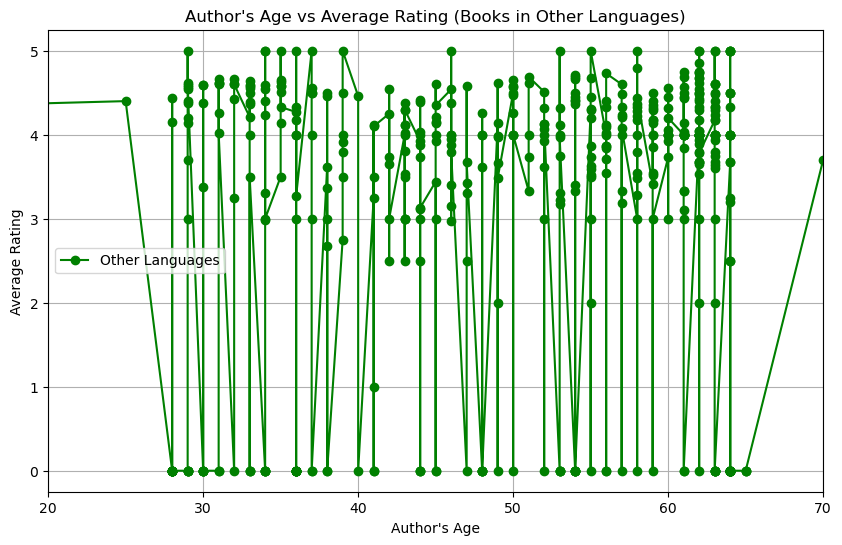

In [97]:
# Author age and average rating (not english)

import pandas as pd
import matplotlib.pyplot as plt

# Clean data: Ensure 'Publication Year' and 'Average Rating' are numeric
df2['Publication Year'] = pd.to_numeric(df2['Publication Year'], errors='coerce')
df2['Average Rating'] = pd.to_numeric(df2['Average Rating'], errors='coerce')

# Calculate author's age at the time of publication
current_year = 2024  # Assuming current year is 2024
neil_age = 64
author_birth_year = current_year - neil_age  # Calculate birth year
df2['Author Age'] = df2['Publication Year'] - author_birth_year

# Filter for books in languages other than English
df_other_languages = df2[df2['Language'] != 'English'].dropna(subset=['Author Age', 'Average Rating']).copy()

# Convert columns to appropriate types
df_other_languages['Author Age'] = df_other_languages['Author Age'].astype(int)
df_other_languages['Average Rating'] = df_other_languages['Average Rating'].astype(float)

# Sort the data by Author Age for a smooth line plot
df_other_languages = df_other_languages.sort_values(by='Author Age')

# Plot: Author's age vs Average Rating (Other Languages)
plt.figure(figsize=(10, 6))
plt.plot(df_other_languages['Author Age'], df_other_languages['Average Rating'], marker='o', linestyle='-', color='green', label='Other Languages')

# Add labels, title, and grid
plt.title("Author's Age vs Average Rating (Books in Other Languages)")
plt.xlabel("Author's Age")
plt.ylabel("Average Rating")
plt.xticks(range(20, 71, 10))  # Set x-axis ticks from 20 to 70 with intervals of 10
plt.xlim(20, 70)  # Set the x-axis limits to start at 20 and end at 70
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

'''
Author's Age and Rating (Books in Languages Other Than English): 

Spread Out Ratings at Early Ages:

In the earlier ages, ratings for non-English books are more varied, ranging from 2.5 to 5.
This suggests that the author wrote fewer non-English books during their younger years, 
but these books received more diverse feedback.

Lowest Ratings at Later Ages:

Contrary to the English-only analysis, the lowest average ratings for non-English books occur at later ages.
This may reflect differences in audience preferences or the author's experimentation with 
different genres or styles in non-English markets.

Constant Relationship:

Similar to the English-only analysis, the overall trend is constant, with average ratings 
generally fluctuating between 3 to 5 across all ages.

Congestion at Later Ages:

In the later ages, the line plot becomes more congested, indicating that the 
author wrote more non-English books during this time.
This could reflect a shift in focus or a broader audience appeal in non-English markets 
during the later stages of their career.

Consistent High Ratings:

Despite the spread at earlier ages and congestion at later ages, the ratings tend to remain high, 
showcasing the author's ability to maintain quality across languages.

Key Insight:

Including books in languages other than English reveals greater variability in ratings at early ages, 
with lowest ratings occurring later. 
The relationship remains largely constant, with fluctuations within a 3 to 5 range, 
but the line plot suggests an increase in the author's productivity in non-English markets later in life. 
While the patterns differ slightly, the overall interpretation of a stable relationship between age and ratings persists.
'''



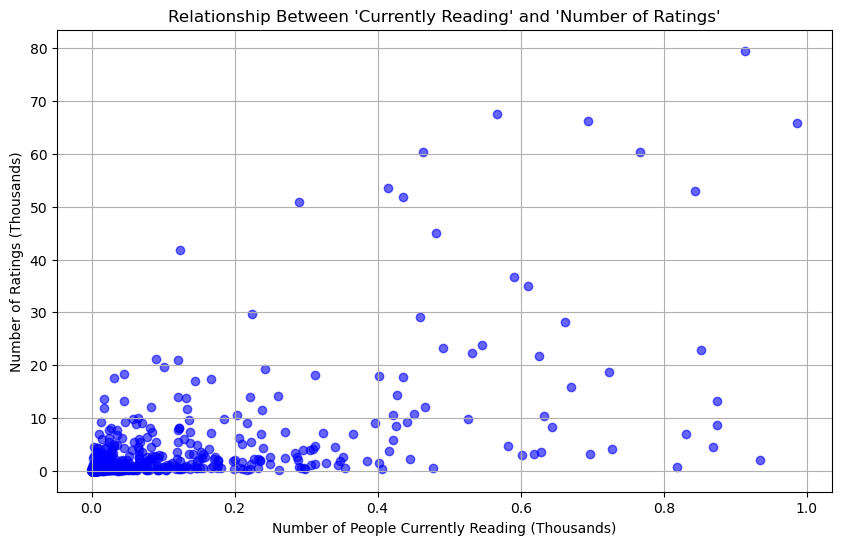

In [111]:
# Number of ratings VS number of people currently reading

import pandas as pd
import matplotlib.pyplot as plt

# Ensure columns are numeric
df['Currently Reading'] = pd.to_numeric(df['Currently Reading'], errors='coerce')
df['Number of Ratings'] = pd.to_numeric(df['Number of Ratings'], errors='coerce')

# Drop rows with missing or invalid data
df_cleaned = df.dropna(subset=['Currently Reading', 'Number of Ratings'])

# Scatterplot: Number of Ratings vs Currently Reading
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['Currently Reading'] / 1000, df_cleaned['Number of Ratings'] / 1000, alpha=0.6, color='blue')  # Scale both axes to thousands
plt.title("Relationship Between 'Currently Reading' and 'Number of Ratings'")
plt.xlabel("Number of People Currently Reading (Thousands)")
plt.ylabel("Number of Ratings (Thousands)")
plt.grid(True)
plt.show()


'''
Interest on a Book: Relationship Between Currently Reading and Number of Ratings

Initial Trend:

When the number of people currently reading is low, the number of ratings is also low.
This suggests a correlation between the immediate interest in a book and its historical popularity 
(as reflected by the number of ratings).

As Interest Grows:

As the number of people currently reading increases, the number of ratings also increases.
This positive trend indicates that books garnering higher interest 
also tend to have accumulated more ratings over time.

Clustering:

There is some clustering near lower values of "Currently Reading," where 
most books seem to have similar levels of interest and ratings.
At higher values of "Currently Reading," the spread of ratings becomes more diverse,
but the overall trend remains positive.

Key Relationship:

There is a positive relationship between the number of people currently reading a book and 
the total number of ratings the book has received.
This suggests that books with higher current interest tend to be more popular or widely read historically.

Insights:
Books with low current interest generally have fewer ratings,
while books with high current interest tend to have more ratings, 
indicating a consistent relationship between interest and popularity.
The scatterplot visually supports this trend, showing a positive correlation between the two variables.
'''


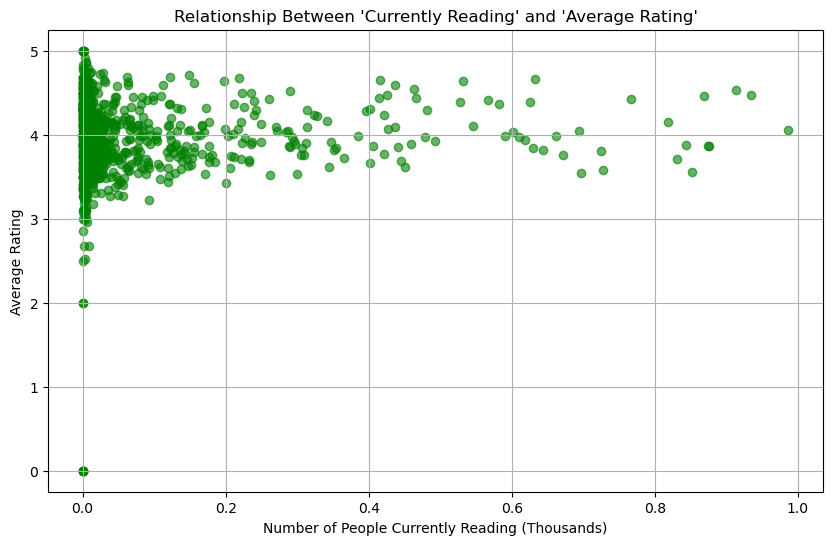

In [113]:
# Average rating VS number of people currently reading

import pandas as pd
import matplotlib.pyplot as plt

# Ensure columns are numeric
df['Currently Reading'] = pd.to_numeric(df['Currently Reading'], errors='coerce')
df['Average Rating'] = pd.to_numeric(df['Average Rating'], errors='coerce')

# Drop rows with missing or invalid data
df_cleaned = df.dropna(subset=['Currently Reading', 'Average Rating'])

# Scatterplot: Average Rating vs Currently Reading
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['Currently Reading'] / 1000, df_cleaned['Average Rating'], alpha=0.6, color='green')  # Scale x-axis to thousands
plt.title("Relationship Between 'Currently Reading' and 'Average Rating'")
plt.xlabel("Number of People Currently Reading (Thousands)")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()

'''
Interest on a Book: Relationship Between Currently Reading and Average Rating

No Clear Positive Trend:

As the number of people currently reading increases, 
the average rating does not show a significant increase or decrease.
The average rating remains fairly constant, fluctuating slightly but staying within a narrow range.

Rating Stability:

Books with both low and high current interest have ratings distributed across the same range, 
indicating that current interest does not necessarily correlate with higher ratings.

Clustering:

There is clustering of ratings between 3.5 and 4.5 for books with varying levels of current interest, 
suggesting that most books fall within this rating range regardless of the number of people currently reading.

Key Relationship:

There is no significant relationship between the number of people currently reading a book and its average rating.
Books with high interest do not tend to have notably higher ratings than those with lower interest.

Insights:
The analysis suggests that current interest in a book does not affect its average rating, 
as ratings remain consistent across different levels of interest. 
This indicates that factors influencing average ratings are likely independent of current readership trends.
'''



In [115]:
import pandas as pd

# Save the DataFrame to a CSV file
file_path = 'scraped_book_writer.csv'  # Specify your desired file name
df3.to_csv(file_path, index=False)

print(f"CSV file saved at: {file_path}")

CSV file saved at: scraped_book_writer.csv
